In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import pickle
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import chi2_contingency
import numpy as np

In [2]:
data = pd.read_csv('dados/results-survey292284(4).csv')

In [3]:
# Parse the XML file
tree = ET.parse('dados/survey_292284_pt-BR.xml')

# Get the root element
root = tree.getroot()

In [4]:
sections = [element for element in root.iter() if element.tag == 'section']
section_names = [section.get('id') for section in sections]
section_names

['1230', '698', '699', '697', '695', '694', '701', '700', '693']

In [5]:
varmap = {}
for section in [root.find(f'.//section[@id="{section_id}"]') for section_id in ['700', '693', '694']]:
    for question in section.findall('.//question'):
        var_name = question.find('response').get('varName')
        text = question.find('text').text if question.find('text') is not None else ""
        varmap[var_name] = text
    for subquestion in section.findall('.//subQuestion'):
        var_name = subquestion.get('varName')
        text = subquestion.find('text').text if subquestion.find('text') is not None else ""
        varmap[var_name] = text
    

In [6]:
varmap['CE06'] = "Você diria que a religião, em sua vida pessoal, é..."

In [7]:
sub_questions_dict = {
    'adc1_SQ001': 'palestra público geral',
    'adc1_SQ002': 'curso público externo',
    'adc1_SQ003': 'aula oficina escola básica',
    'adc1_SQ004': 'comissão técnica ou conselho prof.',
    'adc1_SQ005': 'Pint of Science',
    'adc1_SQ006': 'Dia Ciência Semana Nacional C&T',
    'adc1_SQ007': 'evento ONG movimento social',
    'adc1_SQ008': 'artigo revista público geral',
    'adc1_SQ009': 'entrevista jornal revista público geral',
    'adc1_SQ010': 'livro ou capítulo de divulgação',
    'adc1_SQ011': 'release programa TV rádio',
    'adc1_SQ012': 'audiência pública',
    'adc1_SQ013': 'visita guiada museu',
    'adc1_SQ014': 'programa mídias digitais',
    'adc1_SQ015': 'midias digitais canal próprio'
}


In [8]:
for key in varmap.keys():
    if key in sub_questions_dict:
        varmap[key] = sub_questions_dict[key]

In [9]:
varmap = {
    (key.replace("_", "[") + "]") if "SQ" in key else key: value
    for key, value in varmap.items()
}

In [12]:
atividades = [value for key, value in varmap.items() if "adc1[SQ" in key]

In [11]:
varmap

{'VAL01': 'Quais das seguintes organizações e/ou associações voluntárias você pertence e/ou frequenta?',
 'VAL02': 'Quais das seguintes formas de atuação política você já fez ou poderia vir a fazer?',
 'VAL01[SQ001]': 'Igreja ou grupo religioso',
 'VAL01[SQ002]': 'Associação esportiva ou recreativa',
 'VAL01[SQ003]': 'Associação artística, musical ou educacional',
 'VAL01[SQ004]': 'Sindicato',
 'VAL01[SQ005]': 'Partido político',
 'VAL01[SQ006]': 'Associação de defesa do meio ambiente',
 'VAL01[SQ007]': 'Associação profissional, ou seja, um grupo de profissionais voluntários da mesma área com interesses em comum',
 'VAL01[SQ008]': 'Associação humanitária ou de caridade',
 'VAL01[SQ009]': 'Associação de consumidores',
 'VAL01[SQ010]': 'Grupo de autoajuda, grupo de ajuda mútua',
 'VAL02[SQ001]': 'Assinou um abaixo assinado',
 'VAL02[SQ002]': 'Participou de algum boicote',
 'VAL02[SQ003]': 'Participou de manifestações pacíficas',
 'VAL02[SQ004]': 'Participou de greves',
 'VAL02[SQ005]': '

In [13]:
keys_to_delete = ['CE09', 'CE01', 'CE15'] + [key for key in varmap.keys() if key.startswith('CE12')]
for key in keys_to_delete:
    varmap.pop(key, None)

In [31]:
with open('varmap.pkl', 'wb') as f:
    pickle.dump(varmap, f)

In [16]:
variaveis_demograficas =  [(key, value) for key, value in varmap.items() if "CE" in key]
variaveis_demograficas

[('CE02', 'Qual é o seu sexo?'),
 ('CE03',
  'Até qual série a sua mãe estudou na escola, ou seja, qual a escolaridade dela?'),
 ('CE04', 'Qual sua cor ou raça?'),
 ('CE05',
  'Você pertence a alguma religião ou grupo religioso/espiritualista?'),
 ('CE06', 'Você diria que a religião, em sua vida pessoal, é...'),
 ('CE10', 'A ciência que você desenvolve hoje é melhor identificada como:'),
 ('CE07',
  'Do ponto de vista do posicionamento político, você considera que a expressão que mais se aproxima de sua orientação é...'),
 ('CE08', 'Em qual nível de Bolsa Produtividade do CNPq você se enquadra?'),
 ('CE11', 'Qual é a grande área do conhecimento de sua atuação?'),
 ('CE13', 'Em qual região do Brasil sua instituição se encontra?'),
 ('CE14',
  'Há quantos anos você está vinculado a esta universidade ou instituto de pesquisa?')]

In [17]:
# Obtenha as colunas que são chaves de varmap e também estão presentes no DataFrame data
columns_to_keep = [col for col in varmap.keys() if col in data.columns]

# Filtre o DataFrame data mantendo apenas as colunas especificadas
df = data[columns_to_keep]


In [18]:
df.head()

,VAL01[SQ001],VAL01[SQ002],VAL01[SQ003],VAL01[SQ004],VAL01[SQ005],VAL01[SQ006],VAL01[SQ007],VAL01[SQ008],VAL01[SQ009],VAL01[SQ010],...,adc1[SQ013],adc1[SQ014],adc1[SQ015],adc3[SQ001],adc3[SQ002],adc3[SQ003],adc3[SQ004],adc6[SQ001],adc6[SQ002],adc6[SQ003]
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,...,Nenhuma vez,Nenhuma vez,Nenhuma vez,Muito importante,NaN,Importante,Importante,Raramente,Nunca,Nunca
2,Pertenço e frequento,"Pertenço, mas não frequento muito",Não pertenço,Pertenço e frequento,Não pertenço,Não pertenço,Pertenço e frequento,Não pertenço,Não pertenço,Não pertenço,...,1 vez,2 vezes,3 vezes,Muito importante,NaN,Muito importante,Importante,Raramente,Frequentemente,NaN
3,"Pertenço, mas não frequento muito",Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,...,1 vez,Nenhuma vez,Nenhuma vez,Muito importante,Muito importante,Muito importante,Muito importante,Frequentemente,Nunca,Nunca
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df.dropna(inplace=True)

C:\Users\mapereira\AppData\Local\Temp\ipykernel_10456\1379821321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [20]:
df.CE05 = df.CE05.str.split("(").str[0]

C:\Users\mapereira\AppData\Local\Temp\ipykernel_10456\83487144.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.CE05 = df.CE05.str.split("(").str[0]


In [32]:
df.to_csv('data_tratado.csv', index=False)

In [34]:
def plot_grouped_bar_chart(data, varmap, ordered_categories):    
    # Filtrar as colunas que começam com 'adc1'
    adc1_columns = [col for col in data.columns if col.startswith('adc1')]

    # Subplot títulos
    titles = [value for key, value in varmap.items() if key in adc1_columns]

    # Calcular a contagem dos valores de cada coluna e preparar os dados
    data_counts = pd.DataFrame({col: data[col].value_counts().reindex(ordered_categories) for col in adc1_columns})
    data_counts = data_counts.T  # Transpor para que as atividades sejam as linhas
    data_counts.index = titles
    data_counts.sort_values(by="Nenhuma vez", inplace=True)  # Ordenar as atividades pela contagem de "Nenhuma vez"

    # Lista de textos para a legenda
    legend_texts = ["Nenhuma", "1 vez", "2 vezes", "3 vezes", "4 vezes", "5 vezes", "Mais de 5 vezes"]

    # Criar o gráfico de barras agrupadas
    fig = go.Figure()

    for category in ordered_categories:
        fig.add_trace(go.Bar(
            x=data_counts.index,
            y=data_counts[category],
            name=category,
            width=0.13,
            marker=dict(line=dict(width=1))
        ))

    # Atualizar o layout do gráfico
    fig.update_layout(
        barmode='group',
        title='Frequência das atividades de divulgação científica da amostra',
        title_font=dict(size=18),  # Tamanho da fonte do título
        title_x=0.5,  # Centralizar o título
        xaxis_title='',
        yaxis_title='',
        template='plotly_dark',
        legend=dict(font=dict(size=18)),
        height=800,
        xaxis=dict(
            tickmode='array',
            tickvals=[i for i in range(len(data_counts.index))],
            ticktext=[f'{" ".join(title.split()[:3])}<br>{" ".join(title.split()[3:])}' for title in data_counts.index],
            tickfont=dict(size=16),
        ),
        yaxis=dict(
            tickfont=dict(size=16),
        ),
    )
    
    # Exibir o gráfico
    fig.show()


### Gráfico de Barras empilhadas

In [21]:
# Aplicar a transformação de categorias ordenadas a todas as colunas que começam com 'adc1'

ordered_categories = ['Nenhuma vez', '1 vez', '2 vezes', '3 vezes', '4 vezes', '5 vezes', 'mais de 5 vezes']

dff = df.copy()

for col in dff.columns:
    if col.startswith('adc1'):
        dff.loc[:, col] = pd.Categorical(dff.loc[:, col], categories=ordered_categories, ordered=True)

In [25]:
# Exemplo de agregação dos dados
dff_melted = dff.melt(value_vars=[col for col in dff.columns if col.startswith('adc1')], 
                    var_name='Atividade', value_name='Frequência')


dff_melted['Atividade'] = dff_melted['Atividade'].map(varmap)

dff_freq = dff_melted.groupby(['Atividade', 'Frequência']).size().reset_index(name='Contagem')

# Garantir que a coluna 'Frequência' seja categórica e ordenada
dff_freq['Frequência'] = pd.Categorical(
    dff_freq['Frequência'], 
    categories=ordered_categories, 
    ordered=True
)

# Ordenar o DataFrame com base nas categorias
dff_freq = dff_freq.sort_values(['Atividade', 'Frequência'])

# Calcular a soma das contagens para "Nenhuma vez" em cada atividade
order_by_nenhuma_vez = (
    dff_freq[dff_freq['Frequência'] == 'Nenhuma vez']
    .set_index('Atividade')['Contagem']
    .sort_values(ascending=False)
)

# Ordenar as atividades com base na ordem decrescente de "Nenhuma vez"
ordered_activities = order_by_nenhuma_vez.index.tolist()

# Criar o gráfico com a ordem específica das atividades
fig = px.bar(
    dff_freq, 
    x='Atividade', 
    y='Contagem', 
    color='Frequência', 
    title='Distribuição das Respostas por Atividade',
    category_orders={
        'Frequência': ordered_categories,  # Ordem das categorias de frequência
        'Atividade': ordered_activities    # Ordem das atividades
    }
)

fig.show()

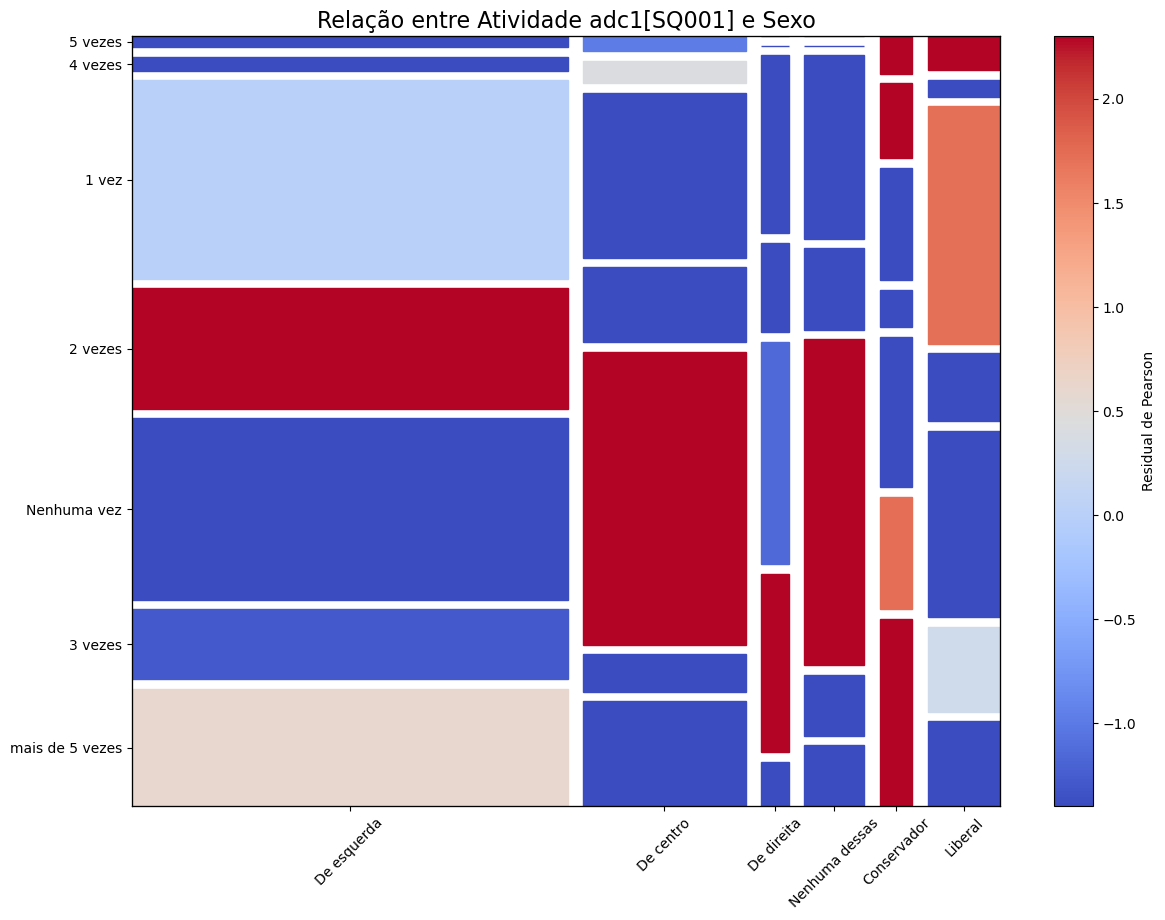

In [42]:
# Reordenar a coluna adc1[SQ001] conforme a ordem desejada
#ordered_categories = ['Nenhuma vez', '1 vez', '2 vezes', '3 vezes', '4 vezes', '5 vezes', 'mais de 5 vezes']
#df.loc[:, 'adc1[SQ001]'] = pd.Categorical(df.loc[:, 'adc1[SQ001]'], categories=ordered_categories, ordered=True)

# Criar tabela de contingência
contingency_table = pd.crosstab(df['adc1[SQ001]'], df['CE07'])

# Calcular o teste de qui-quadrado e obter os resíduos de Pearson
chi2, p, dof, expected = chi2_contingency(contingency_table)
residuals = (contingency_table - expected) / np.sqrt(expected)

# Função para mapear a cor dos blocos com base nos resíduos de Pearson
def residual_color(key):
    value = residuals.loc[key[1], key[0]]  # Ajusta para o eixo correto
    color = plt.cm.coolwarm(value)  # Mapeia o valor do residual para a cor
    return {'color': color}

# Criar uma nova figura com tamanho aumentado
fig, ax = plt.subplots(figsize=(14, 10))  # Ajusta o tamanho conforme necessário

# Criar o gráfico de mosaico
mosaic(df, ['CE07', 'adc1[SQ001]'], properties=residual_color, ax=ax, gap=0.02, labelizer=lambda k: '')

# Adicionar uma linha para separar os blocos
# ax.grid(True, which='both', axis='both', color='black', linewidth=0.5)

# Adicionar a legenda para as cores dos resíduos de Pearson
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=residuals.min().min(), vmax=residuals.max().max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Residual de Pearson')

# Ajustar os rótulos do eixo x
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Adicionar título ao gráfico
ax.set_title('Relação entre Atividade adc1[SQ001] e Sexo', fontsize=16)

plt.show()

In [23]:
def plot_mosaic(df, activity_col, interest_var):
    """
    Plota um gráfico de mosaico para a coluna de atividade e a variável de interesse.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo os dados.
    activity_col (str): Nome da coluna de atividade para plotar.
    interest_var (str): Nome da variável de interesse para plotar.
    ordered_categories (list, opcional): Lista de categorias ordenadas para a coluna de atividade.
    """
    
    ordered_categories = ['Nenhuma vez', '1 vez', '2 vezes', '3 vezes', '4 vezes', '5 vezes', 'mais de 5 vezes']

    # Verificar e aplicar categorias ordenadas
    if ordered_categories:
        df[activity_col] = pd.Categorical(df[activity_col], categories=ordered_categories, ordered=True)

    # Criar tabela de contingência
    contingency_table = pd.crosstab(df[activity_col], df[interest_var])
    contingency_table = contingency_table.reindex(ordered_categories, axis=0)

    # Calcular o teste de qui-quadrado e obter os resíduos de Pearson
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    residuals = (contingency_table - expected) / np.sqrt(expected)

    # Função para mapear a cor dos blocos com base nos resíduos de Pearson
    def residual_color(key):
        if key[1] in residuals.index and key[0] in residuals.columns:
            value = residuals.loc[key[1], key[0]]  # Ajusta para o eixo correto
            color = plt.cm.coolwarm(value)  # Mapeia o valor do residual para a cor
            return {'color': color}
        else:
            return {'color': 'grey'}  # Cor padrão para valores fora da tabela

    # Criar uma nova figura com tamanho aumentado
    fig, ax = plt.subplots(figsize=(14, 10))  # Ajuste o tamanho conforme necessário

    # Criar o gráfico de mosaico
    mosaic(df, [interest_var, activity_col], properties=residual_color, ax=ax, gap=0.02, labelizer=lambda k: '')

    # Adicionar a legenda para as cores dos resíduos de Pearson
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=residuals.min().min(), vmax=residuals.max().max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Residual de Pearson')

    # Ajustar os rótulos do eixo x
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    # Adicionar título ao gráfico
    ax.set_title(f'Relação entre {activity_col} e {interest_var}', fontsize=16)

    plt.show()

C:\Users\MAPERE~1\AppData\Local\Temp/ipykernel_21744/2914412568.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[activity_col] = pd.Categorical(df[activity_col], categories=ordered_categories, ordered=True)


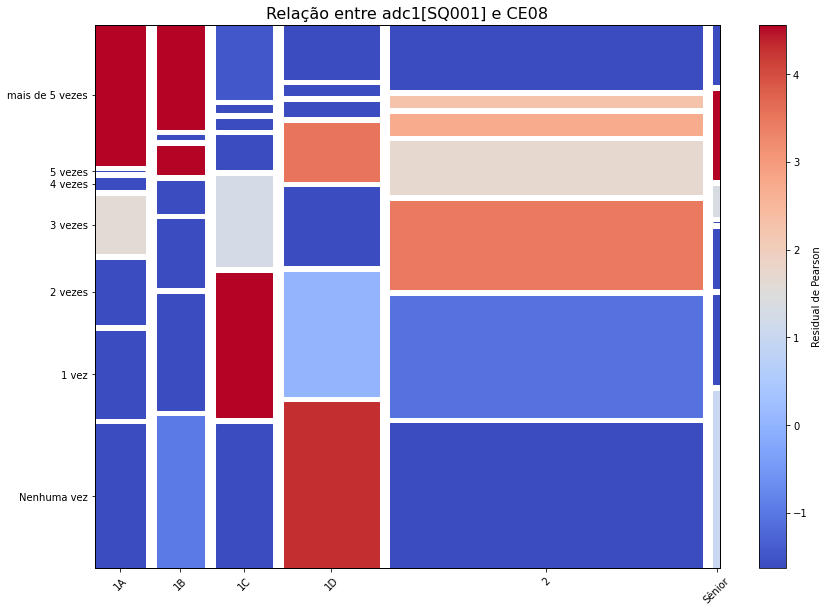

In [24]:
plot_mosaic(df, 'adc1[SQ001]', 'CE08')


In [21]:
ordered_categories = ['Nenhuma vez', '1 vez', '2 vezes', '3 vezes', '4 vezes', '5 vezes', 'mais de 5 vezes']

df.loc[:, 'adc1[SQ001]'] = pd.Categorical(df.loc[:, 'adc1[SQ001]'], categories=ordered_categories, ordered=True)

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [22]:
df['adc1[SQ001]'].unique()

[NaN, 'mais de 5 vezes', '2 vezes', 'Nenhuma vez', '4 vezes', '3 vezes', '1 vez', '5 vezes']
Categories (7, object): ['Nenhuma vez' < '1 vez' < '2 vezes' < '3 vezes' < '4 vezes' < '5 vezes' < 'mais de 5 vezes']

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import chi2_contingency
from io import BytesIO
import base64

def plot_mosaic(df, activity_col, interest_var, ordered_categories=None):

    ordered_categories = ['Nenhuma vez', '1 vez', '2 vezes', '3 vezes', '4 vezes', '5 vezes', 'mais de 5 vezes']
    
    # Verificar e aplicar categorias ordenadas
    if ordered_categories:
        df[activity_col] = pd.Categorical(df[activity_col], categories=ordered_categories, ordered=True)

    # Criar tabela de contingência
    contingency_table = pd.crosstab(df[activity_col], df[interest_var])
    contingency_table = contingency_table.reindex(ordered_categories, axis=0)

    # Calcular o teste de qui-quadrado e obter os resíduos de Pearson
    chi2_stat, p, dof, expected = chi2_contingency(contingency_table)
    residuals = (contingency_table - expected) / np.sqrt(expected)

    # Pontos de corte para o esquema de coloração
    cutoff_05 = 2
    cutoff_001 = 4

    # Função para mapear a cor dos blocos com base nos resíduos de Pearson
    def residual_color(key):
        if key[1] in residuals.index and key[0] in residuals.columns:
            value = residuals.loc[key[1], key[0]]  # Ajusta para o eixo correto
            if value >= cutoff_001:
                return {'color': 'red'}
            elif value >= cutoff_05:
                return {'color': 'lightcoral'}  # Substituindo por uma cor mais intensa
            elif value <= -cutoff_001:
                return {'color': 'blue'}
            elif value <= -cutoff_05:
                return {'color': 'dodgerblue'}  # Substituindo por uma cor mais intensa
            else:
                return {'color': 'lightgrey'}  # Cor neutra para resíduos não significativos
        else:
            return {'color': 'lightgrey'}  # Cor padrão para valores fora da tabela

    # Criar uma nova figura com tamanho aumentado
    fig, ax = plt.subplots(figsize=(14, 10))  # Ajuste o tamanho conforme necessário

    # Criar o gráfico de mosaico
    mosaic(df, [interest_var, activity_col], properties=residual_color, ax=ax, gap=0.02, labelizer=lambda k: '')

    # Adicionar a legenda para as cores dos resíduos de Pearson
    bounds = [-cutoff_001, -cutoff_05, cutoff_05, cutoff_001]
    cmap = plt.cm.RdBu_r  # Colormap invertido para ter azul para valores negativos e vermelho para positivos
    norm = plt.Normalize(vmin=-cutoff_001, vmax=cutoff_001)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Configurando a barra de cores com ticks personalizados
    cbar = plt.colorbar(sm, ax=ax, ticks=[-cutoff_001, -cutoff_05, cutoff_05, cutoff_001])
    cbar.ax.set_yticklabels(['<= -4', '-2', '2', '>= 4'])  # Labels nos limites de ±2 e ±4

    # Adicionar valor de p abaixo da barra de cores
    cbar.ax.text(0.5, -0.1, f'p-valor: {p:.3f}', transform=cbar.ax.transAxes, fontsize=12, 
                 verticalalignment='top', horizontalalignment='center', 
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    # Ajustar os rótulos do eixo x
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    # Adicionar título ao gráfico
    ax.set_title(f'Relação entre {activity_col} e {interest_var}', fontsize=16)

    # Salvar em um buffer temporário
    buf = BytesIO()
    plt.savefig(buf, format="png")
    # Embutir o resultado na saída HTML
    data = base64.b64encode(buf.getbuffer()).decode("utf8")
    fig_mosaic_matplotlib = f'data:image/png;base64,{data}'

    return fig_mosaic_matplotlib

In [48]:
ordered_categories = ['Nenhuma vez', '1 vez', '2 vezes', '3 vezes', '4 vezes', '5 vezes', 'mais de 5 vezes']

C:\Users\mapereira\AppData\Local\Temp\ipykernel_9344\3432918112.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



''
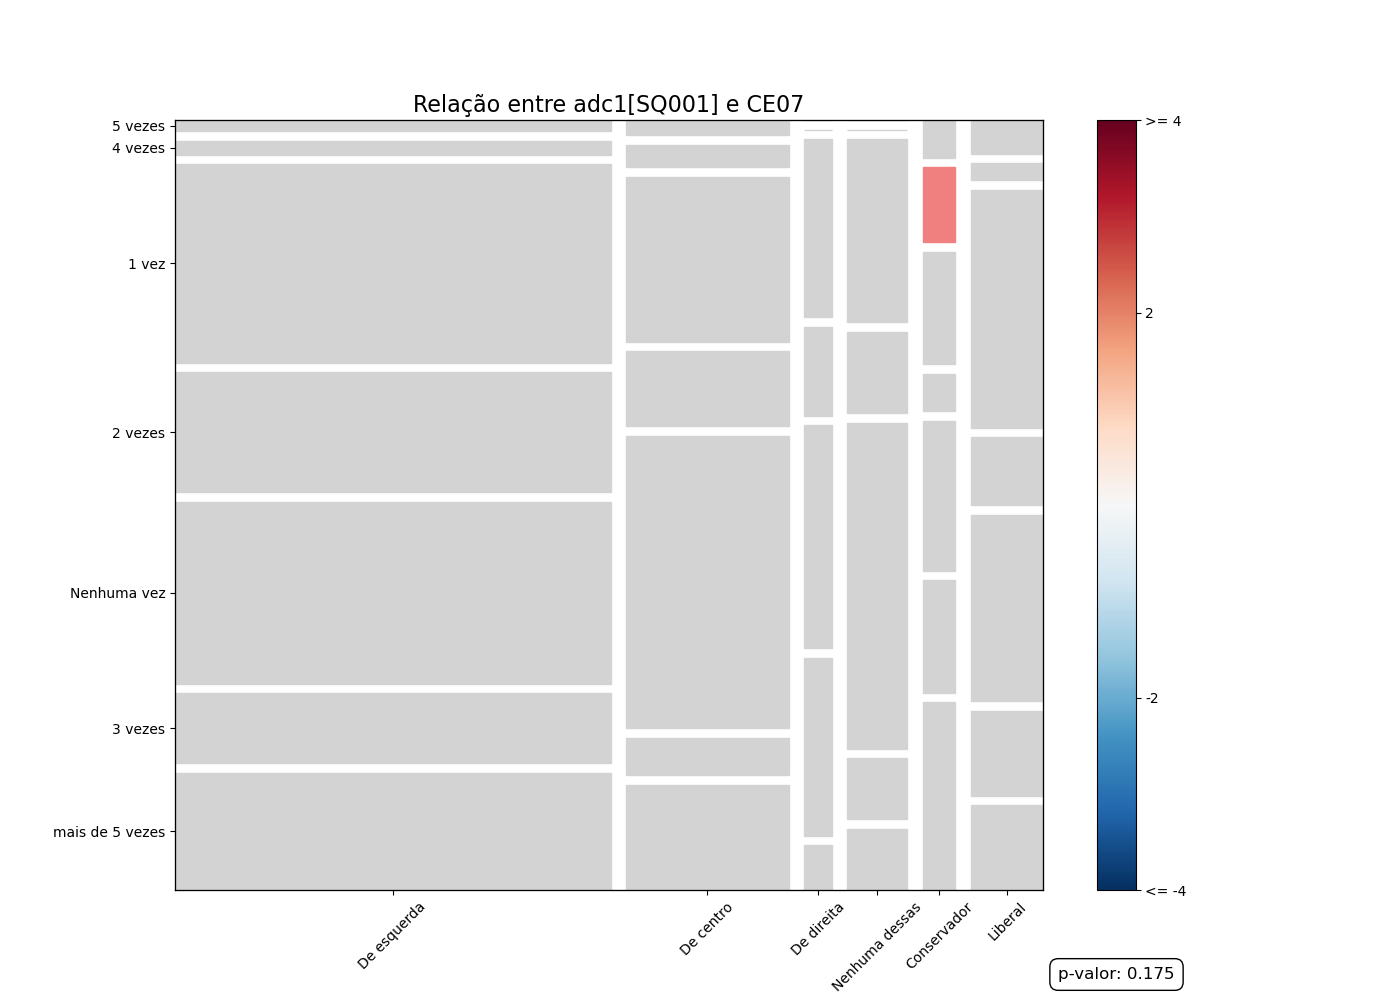

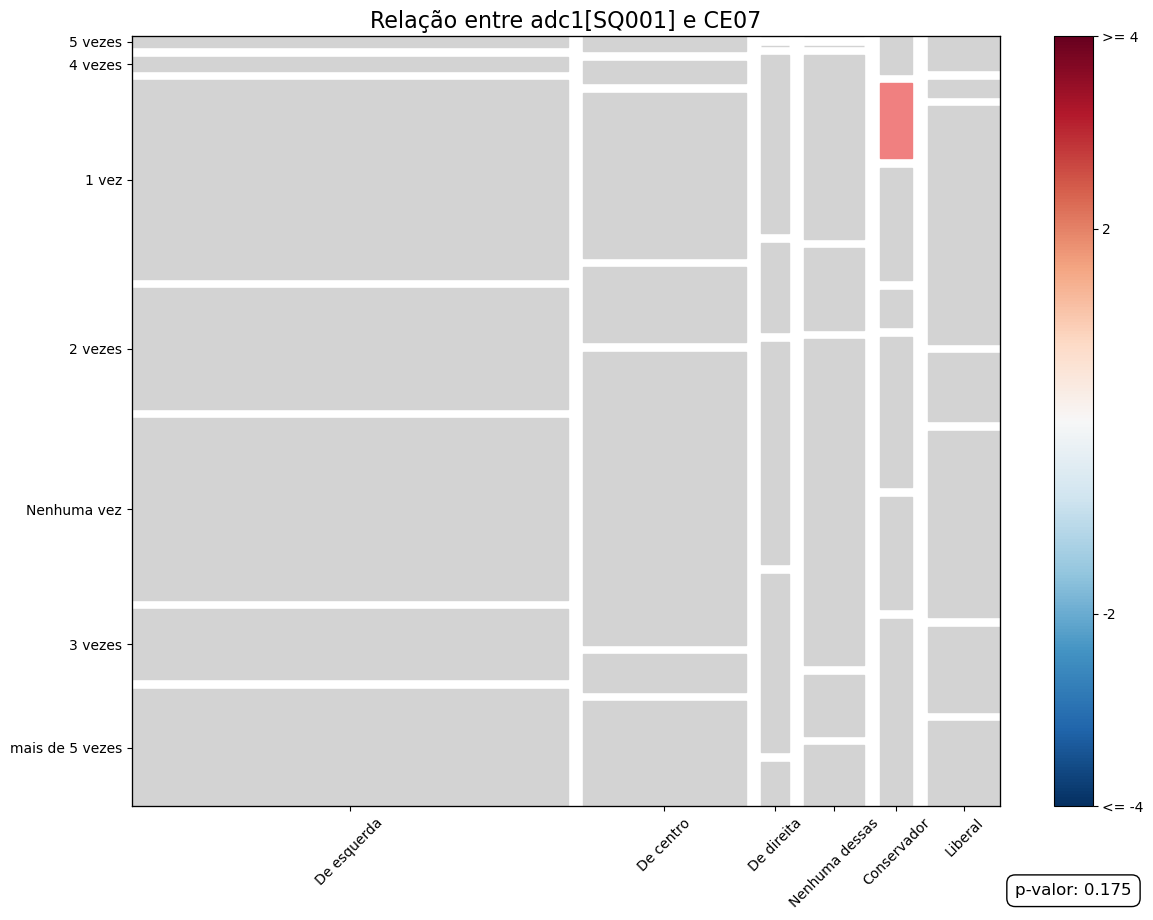

In [50]:
plot_mosaic(df, 'adc1[SQ001]', 'CE07', ordered_categories)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import chi2_contingency
from io import BytesIO
import base64

def plot_mosaic(df, activity_col, interest_var):

    ordered_categories = ['Nenhuma vez', '1 vez', '2 vezes', '3 vezes', '4 vezes', '5 vezes', 'mais de 5 vezes']

    # Verificar e aplicar categorias ordenadas
    if ordered_categories:
        df[activity_col] = pd.Categorical(df[activity_col], categories=ordered_categories, ordered=True)

    # Criar uma nova coluna que representa a ordem das categorias
    df['activity_order'] = df[activity_col].apply(lambda x: ordered_categories.index(x))

    # Ordenar o DataFrame pela nova coluna
    df = df.sort_values('activity_order')

    # Criar tabela de contingência
    contingency_table = pd.crosstab(df[activity_col], df[interest_var])

    # Calcular o teste de qui-quadrado e obter os resíduos de Pearson
    chi2_stat, p, dof, expected = chi2_contingency(contingency_table)
    residuals = (contingency_table - expected) / np.sqrt(expected)

    # Pontos de corte para o esquema de coloração
    cutoff_05 = 2
    cutoff_001 = 4

    # Função para mapear a cor dos blocos com base nos resíduos de Pearson
    def residual_color(key):
        if key[1] in residuals.index and key[0] in residuals.columns:
            value = residuals.loc[key[1], key[0]]  # Ajusta para o eixo correto
            if value >= cutoff_001:
                return {'color': 'red'}
            elif value >= cutoff_05:
                return {'color': 'lightcoral'}  # Substituindo por uma cor mais intensa
            elif value <= -cutoff_001:
                return {'color': 'blue'}
            elif value <= -cutoff_05:
                return {'color': 'dodgerblue'}  # Substituindo por uma cor mais intensa
            else:
                return {'color': 'lightgrey'}  # Cor neutra para resíduos não significativos
        else:
            return {'color': 'lightgrey'}  # Cor padrão para valores fora da tabela

    # Criar uma nova figura com tamanho aumentado
    fig, ax = plt.subplots(figsize=(14, 10))  # Ajuste o tamanho conforme necessário

    # Criar o gráfico de mosaico
    mosaic(df, [interest_var, activity_col], properties=residual_color, ax=ax, gap=0.02, labelizer=lambda k: '')

    # Adicionar a legenda para as cores dos resíduos de Pearson
    bounds = [-cutoff_001, -cutoff_05, cutoff_05, cutoff_001]
    cmap = plt.cm.RdBu_r  # Colormap invertido para ter azul para valores negativos e vermelho para positivos
    norm = plt.Normalize(vmin=-cutoff_001, vmax=cutoff_001)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Configurando a barra de cores com ticks personalizados
    cbar = plt.colorbar(sm, ax=ax, ticks=[-cutoff_001, -cutoff_05, cutoff_05, cutoff_001])
    cbar.ax.set_yticklabels(['<= -4', '-2', '2', '>= 4'])  # Labels nos limites de ±2 e ±4

    # Adicionar valor de p abaixo da barra de cores
    cbar.ax.text(0.5, -0.1, f'p-valor: {p:.3f}', transform=cbar.ax.transAxes, fontsize=12, 
                 verticalalignment='top', horizontalalignment='center', 
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    # Ajustar os rótulos do eixo x
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    # Adicionar título ao gráfico
    # ax.set_title(f'Relação entre {activity_col} e {interest_var}', fontsize=16)

    # Reposicionar a barra de legenda
    fig.subplots_adjust(left=0.1, right=0.8, top=0.95, bottom=0.15)
    cbar.ax.set_position([0.85, 0.15, 0.03, 0.8])  # left, bottom, width, height

    # Salvar em um buffer temporário
    buf = BytesIO()
    plt.savefig(buf, format="png")
    # Embutir o resultado na saída HTML
    data = base64.b64encode(buf.getbuffer()).decode("utf8")
    fig_mosaic_matplotlib = f'data:image/png;base64,{data}'

    return fig_mosaic_matplotlib


C:\Users\MAPERE~1\AppData\Local\Temp/ipykernel_13000/3061839162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[activity_col] = pd.Categorical(df[activity_col], categories=ordered_categories, ordered=True)
C:\Users\MAPERE~1\AppData\Local\Temp/ipykernel_13000/3061839162.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['activity_order'] = df[activity_col].apply(lambda x: ordered_categories.index(x))


''
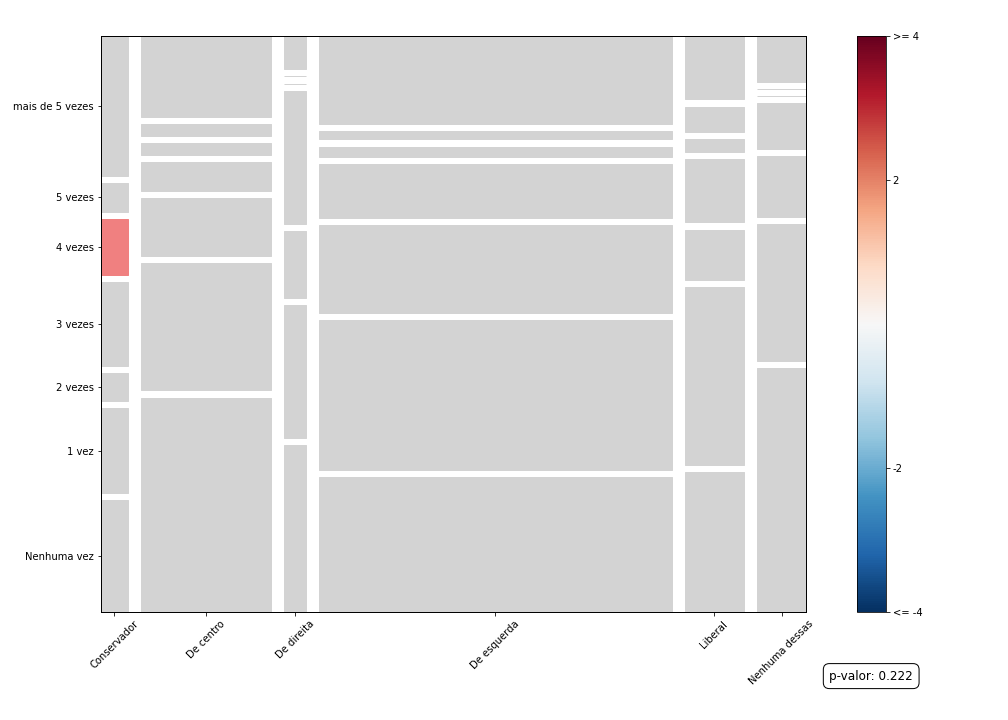

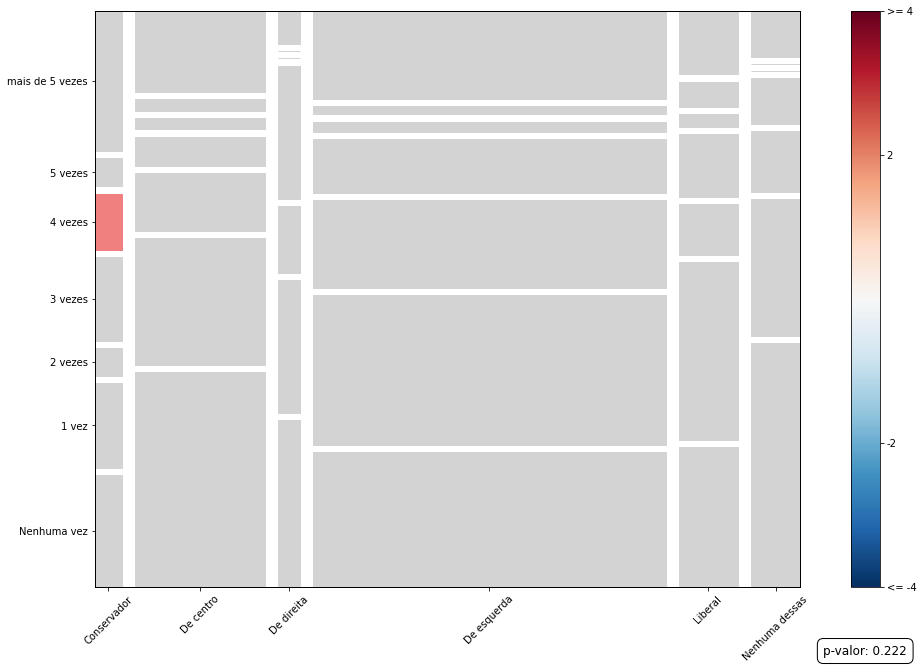

In [21]:
plot_mosaic(df, 'adc1[SQ001]', 'CE07')

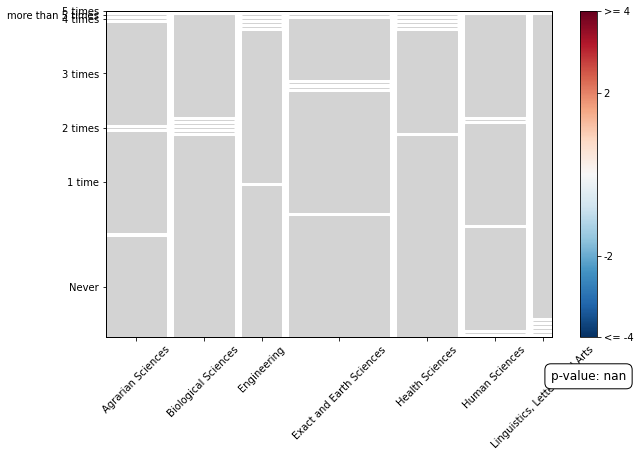

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import chi2_contingency
import numpy as np
from io import BytesIO
import base64

# Create a sample DataFrame
data = {
    'adc1[SQ001]': ['1 time', '2 times', 'Never', 'more than 5 times', 'Never',
                     '3 times', 'Never', 'Never', 'Never', '1 time',
                     '1 time', 'Never', 'Never', '3 times', 'more than 5 times',
                     '1 time', 'more than 5 times', '1 time', 'Never', '4 times'],
    'CE11': ['Exact and Earth Sciences', 'Human Sciences', 'Health Sciences', 
             'Linguistics, Letters and Arts', 'Exact and Earth Sciences', 'Agrarian Sciences',
             'Biological Sciences', 'Exact and Earth Sciences', 'Agrarian Sciences',
             'Engineering', 'Health Sciences', 'Biological Sciences', 'Engineering',
             'Human Sciences', 'Biological Sciences', 'Exact and Earth Sciences',
             'Human Sciences', 'Agrarian Sciences', 'Health Sciences',
             'Exact and Earth Sciences']
}

df = pd.DataFrame(data)

# Define ordered categories
ordered_categories = ['Never', '1 time', '2 times', '3 times', '4 times', '5 times', 'more than 5 times']

# Convert the column to an ordered categorical type
df['adc1[SQ001]'] = pd.Categorical(df['adc1[SQ001]'], categories=ordered_categories, ordered=True)

# Create the contingency table
contingency_table = pd.crosstab(df['adc1[SQ001]'], df['CE11'])
contingency_table = contingency_table.reindex(ordered_categories, axis=0)

# Calculate the chi-square test
chi2_stat, p, dof, expected = chi2_contingency(contingency_table)
residuals = (contingency_table - expected) / np.sqrt(expected)

# Function to map block colors based on Pearson residuals
def residual_color(key):
    if key[1] in residuals.index and key[0] in residuals.columns:
        value = residuals.loc[key[1], key[0]]
        if value >= 4:
            return {'color': 'red'}
        elif value >= 2:
            return {'color': 'lightcoral'}
        elif value <= -4:
            return {'color': 'blue'}
        elif value <= -2:
            return {'color': 'dodgerblue'}
        else:
            return {'color': 'lightgrey'}
    else:
        return {'color': 'lightgrey'}

# Create the mosaic plot
fig, ax = plt.subplots(figsize=(10, 6))
mosaic(df, ['CE11', 'adc1[SQ001]'], properties=residual_color, ax=ax, gap=0.02, labelizer=lambda k: '')

# Add a color legend for Pearson residuals
bounds = [-4, -2, 2, 4]
cmap = plt.cm.RdBu_r
norm = plt.Normalize(vmin=-4, vmax=4)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=[-4, -2, 2, 4])
cbar.ax.set_yticklabels(['<= -4', '-2', '2', '>= 4'])
cbar.ax.text(0.5, -0.1, f'p-value: {p:.3f}', transform=cbar.ax.transAxes, fontsize=12, 
             verticalalignment='top', horizontalalignment='center', 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Adjust x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Show the plot
plt.show()


In [34]:
[value for key, value in varmap.items() if "adc1[SQ" in key]

['palestra público geral',
 'curso público externo',
 'aula oficina escola básica',
 'comissão técnica ou conselho prof.',
 'Pint of Science',
 'Dia Ciência Semana Nacional C&T',
 'evento ONG movimento social',
 'artigo revista público geral',
 'entrevista jornal revista público geral',
 'livro ou capítulo de divulgação',
 'release programa TV rádio',
 'audiência pública',
 'visita guiada museu',
 'programa mídias digitais',
 'midias digitais canal próprio']

In [2]:
import pandas as pd
import re

In [3]:
df = pd.read_csv('data_tratado.csv')
df.head()

,VAL01[SQ001],VAL01[SQ002],VAL01[SQ003],VAL01[SQ004],VAL01[SQ005],VAL01[SQ006],VAL01[SQ007],VAL01[SQ008],VAL01[SQ009],VAL01[SQ010],...,adc1[SQ013],adc1[SQ014],adc1[SQ015],adc3[SQ001],adc3[SQ002],adc3[SQ003],adc3[SQ004],adc6[SQ001],adc6[SQ002],adc6[SQ003]
0,"Pertenço, mas não frequento muito",Não pertenço,Pertenço e frequento,"Pertenço, mas não frequento muito",Não pertenço,Pertenço e frequento,Pertenço e frequento,Pertenço e frequento,Não pertenço,Não pertenço,...,3 vezes,mais de 5 vezes,mais de 5 vezes,Muito importante,Muito importante,Muito importante,Muito importante,Frequentemente,Raramente,Raramente
1,Não pertenço,Não pertenço,Não pertenço,"Pertenço, mas não frequento muito",Não pertenço,Não pertenço,Pertenço e frequento,Não pertenço,Não pertenço,Não pertenço,...,Nenhuma vez,mais de 5 vezes,Nenhuma vez,Muito importante,Pouco importante,Muito importante,Importante,Frequentemente,Frequentemente,Raramente
2,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,...,Nenhuma vez,Nenhuma vez,Nenhuma vez,Muito importante,Importante,Importante,Nada importante,Raramente,Raramente,Raramente
3,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,"Pertenço, mas não frequento muito",Não pertenço,Não pertenço,Não pertenço,...,Nenhuma vez,mais de 5 vezes,mais de 5 vezes,Muito importante,Importante,Muito importante,Muito importante,Raramente,Frequentemente,Frequentemente
4,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,Não pertenço,"Pertenço, mas não frequento muito",Não pertenço,Não pertenço,...,Nenhuma vez,1 vez,1 vez,Muito importante,Importante,Importante,Nada importante,Nunca,Raramente,Raramente


In [4]:
import re

def extrair_dois_primeiros_numeros(entrada):
    """
    Extrai os dois primeiros números inteiros de uma string.
    Se houver caracteres não numéricos entre os dígitos, retorna apenas o primeiro número.
    
    Parâmetros:
    -----------
    entrada : str
        A string de entrada que pode conter números e texto.
    
    Retorna:
    --------
    int or None
        Retorna os dois primeiros números consecutivos como um inteiro, 
        ou apenas o primeiro número se houver caracteres não numéricos entre eles.
        Retorna None se não houver números.
    """
    # Encontra todos os números na string
    numeros = re.findall(r'\d+', entrada)
    
    if numeros:
        # Se houver mais de um número, verifica se estão consecutivos na string original
        if len(numeros) >= 2:
            # Encontra as posições dos dois primeiros números na string
            primeiro_num = numeros[0]
            segundo_num = numeros[1]
            
            # Verifica se os dois primeiros números estão consecutivos
            posicao_primeiro = entrada.find(primeiro_num)
            posicao_segundo = entrada.find(segundo_num)
            
            # Se houver caracteres não numéricos entre os dois números, retorna apenas o primeiro
            if posicao_segundo > posicao_primeiro + len(primeiro_num):
                return int(primeiro_num)
            else:
                # Retorna os dois primeiros números consecutivos
                return int(primeiro_num + segundo_num)
        else:
            # Retorna o primeiro número se houver apenas um
            return int(numeros[0])
    else:
        return None  # Retorna None se não houver números

In [5]:
ce14_processado = df['CE14'].apply(extrair_dois_primeiros_numeros)

<Axes: >

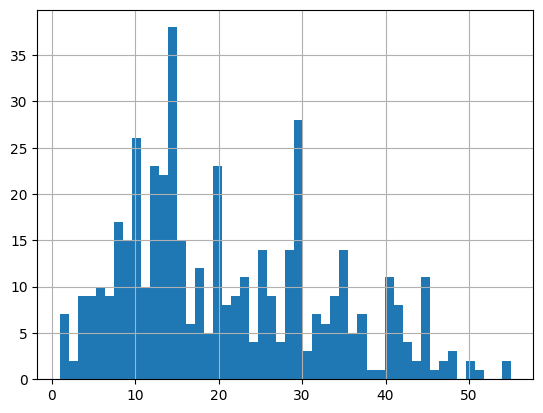

In [6]:
ce14_processado.hist(bins=50)

In [7]:
ce14_processado.describe()

count    459.000000
mean      20.976035
std       12.042749
min        1.000000
25%       12.000000
50%       18.000000
75%       30.000000
max       55.000000
Name: CE14, dtype: float64

In [8]:
def classificar_vinculo(idade):
    if idade <= 5:
        return "Ingressantes"
    elif idade <= 10:
        return "Jovens acadêmicos"
    elif idade <= 20:
        return "Meia carreira"
    elif idade <= 35:
        return "Sêniores"
    else:
        return "Veteranos"

In [9]:
ce14_faixas = ce14_processado.apply(classificar_vinculo)

In [10]:
ce14_faixas.value_counts()

CE14
Meia carreira        154
Sêniores             140
Jovens acadêmicos     77
Veteranos             64
Ingressantes          27
Name: count, dtype: int64

In [11]:
df['CE14'] = ce14_faixas

(0.022445584627482255, <Figure size 1400x1000 with 4 Axes>)

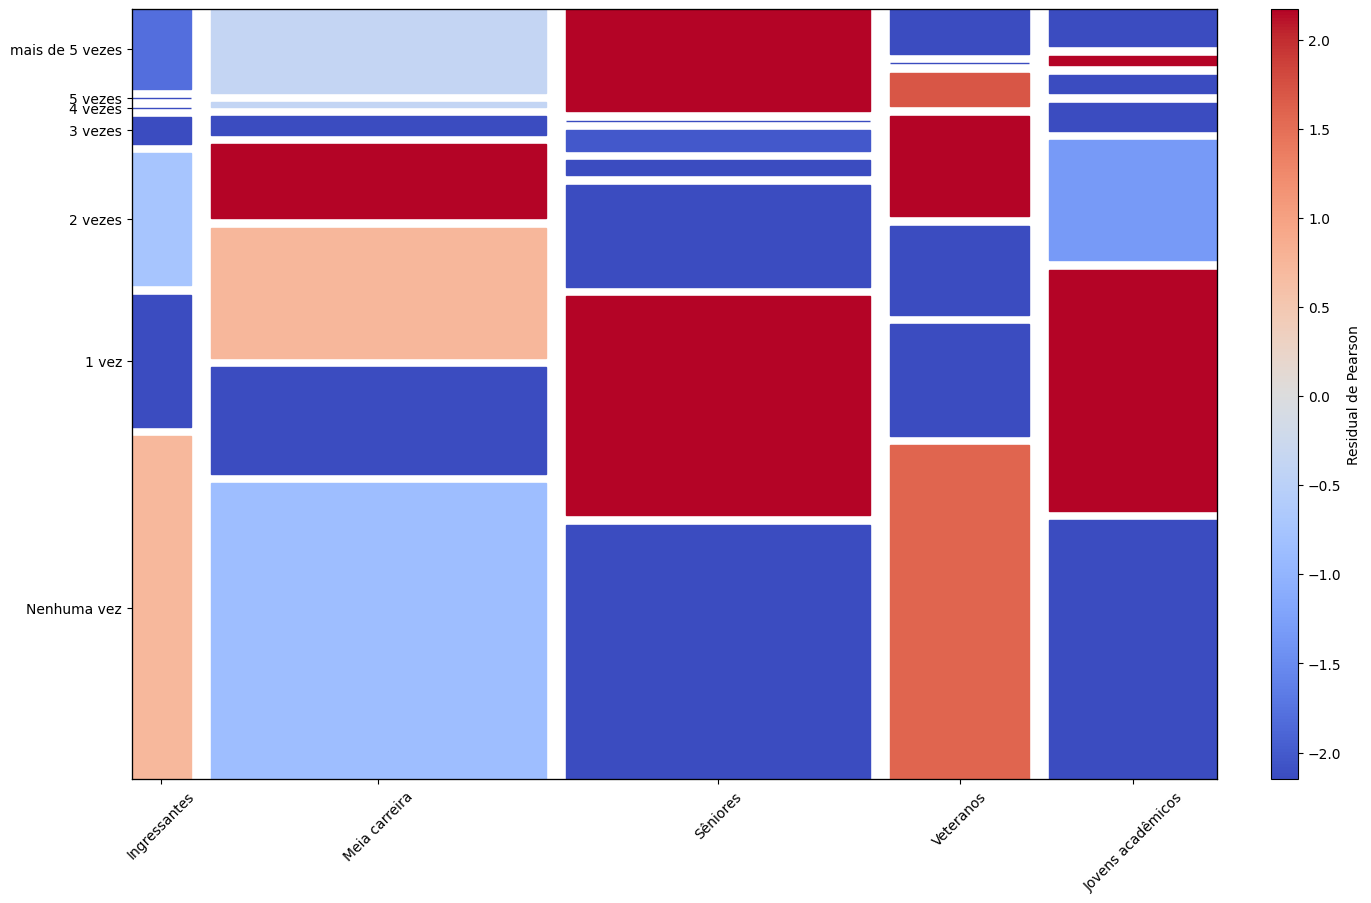

In [14]:
from graphs import plot_mosaic_with_residuals
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import chi2_contingency
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ordered_categories = ['Nenhuma vez', '1 vez', '2 vezes', '3 vezes', '4 vezes', '5 vezes', 'mais de 5 vezes']

plot_mosaic_with_residuals(df, 'adc1[SQ002]', 'CE14', ordered_categories=ordered_categories)

In [19]:
pd.crosstab(df["adc1[SQ001]"], df["CE14"]).sum().sum()

462